In [7]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset

In [4]:
# Load the pre-trained FinBERT tokenizer
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

# Load your trained model from the checkpoint
model = BertForSequenceClassification.from_pretrained('../../results/checkpoint-1000/')



/Users/nikitapiko/Documents/University/WU Wien/SBWL/Data Science/dataenv/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
# Load the labeled dataset again
df_labeled = pd.read_csv("../../../data/processed/processed_for_finbert_labeled_data.csv")

# Define the mapping from sentiment labels to numerical values
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df_labeled['encoded_sentiment'] = df_labeled['sentiment'].map(label_map)

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_labeled['processed_txt'].tolist(), 
    df_labeled['encoded_sentiment'].tolist(), 
    test_size=0.2, 
    random_state=42
)

# Tokenize the validation texts
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

# Create a Dataset object for the validation set
val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': val_labels
})

In [9]:
trainer = Trainer(model=model)

# getting predictions on the validation dataset
predictions = trainer.predict(val_dataset)

# converting predictions  to class labels
import numpy as np
predicted_labels = np.argmax(predictions.predictions, axis=1)

***** Running Prediction *****
  Num examples = 1422
  Batch size = 8


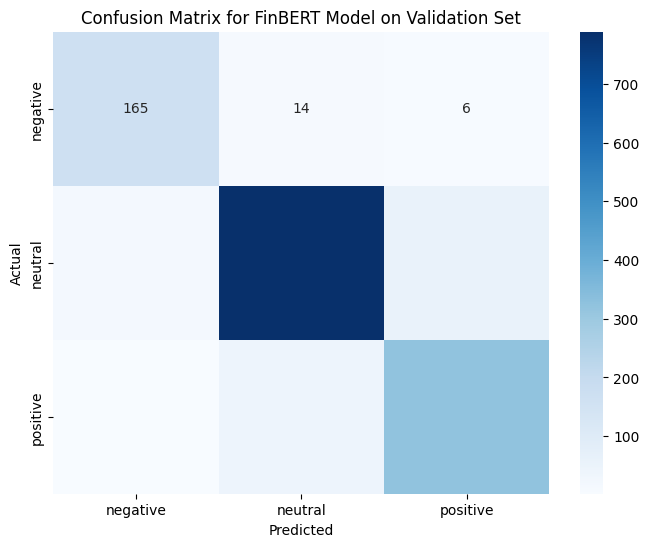

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(val_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for FinBERT Model on Validation Set')
plt.show()

# Optionally save the confusion matrix plot
# plt.savefig('confusion_matrix_finbert.png')


In [11]:
from sklearn.metrics import classification_report
print(classification_report(val_labels, predicted_labels, target_names=['negative', 'neutral', 'positive']))


              precision    recall  f1-score   support

    negative       0.88      0.89      0.89       185
     neutral       0.93      0.91      0.92       869
    positive       0.83      0.88      0.85       368

    accuracy                           0.90      1422
   macro avg       0.88      0.89      0.89      1422
weighted avg       0.90      0.90      0.90      1422



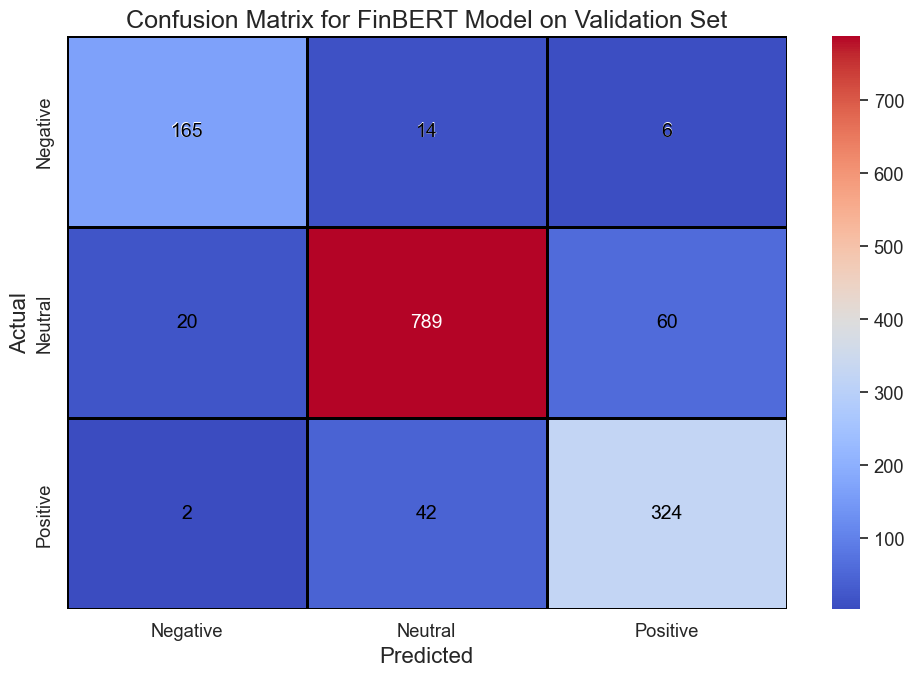

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate the confusion matrix
cm = confusion_matrix(val_labels, predicted_labels)

# Create a function to choose the right color for annotations
def get_text_color(value, threshold):
    """
    Return white or black text color depending on the background color intensity.
    """
    return "white" if value > threshold else "black"

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.2)

# Use a different colormap and plot
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', linewidths=1, linecolor='black', 
                 xticklabels=['Negative', 'Neutral', 'Positive'], 
                 yticklabels=['Negative', 'Neutral', 'Positive'], cbar=True)

# Set the threshold for when to use black vs white text (middle of the color range)
threshold = (cm.max() + cm.min()) / 2

# Loop over the data to change the color of the text annotations based on background color
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = get_text_color(cm[i, j], threshold)
        ax.text(j + 0.5, i + 0.5, cm[i, j], 
                ha="center", va="center", color=color, fontsize=14)

# Improve labeling and title
ax.set_xlabel('Predicted', fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_title('Confusion Matrix for FinBERT Model on Validation Set', fontsize=18)

# Adjust layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()

# Optionally save the confusion matrix plot
# plt.savefig('confusion_matrix_finbert_adjusted.png')
